# Алгоритм для определения уровня навыков игрока на основе анализа результатов бизнес-симуляции

In [9304]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', '{:,.2f}'.format)

In [9305]:
user = pd.read_csv('user.csv')
user_decision = pd.read_csv('user_decision.csv')
team_point = pd.read_csv('team_point.csv')
df = pd.read_csv('train_dataset_train.csv')
decision = pd.read_excel('decision.xlsx', sheet_name = 'decision')
sample_solution = pd.read_csv('sample_solution.csv')

## Знакомство с данными, проверка

In [9306]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  973 non-null    int64
 1   team_id  973 non-null    int64
 2   game_id  973 non-null    int64
dtypes: int64(3)
memory usage: 22.9 KB


In [9307]:
user.head()

,user_id,team_id,game_id
0,10189,1664,235
1,10018,1690,237
2,10580,1394,194
3,10600,1908,262
4,10112,1592,219


In [9308]:
user[user.columns].apply(lambda x: x.nunique())

user_id    973
team_id    214
game_id     43
dtype: int64

In [9309]:
user_decision.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60228 entries, 0 to 60227
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      60228 non-null  int64
 1   period       60228 non-null  int64
 2   decision_id  60228 non-null  int64
dtypes: int64(3)
memory usage: 1.4 MB


In [9310]:
user_decision.head()

,user_id,period,decision_id
0,10625,1,409
1,10318,3,203
2,10775,4,420
3,10236,2,284
4,10130,3,72


In [9311]:
user_decision[user_decision.columns].apply(lambda x: x.nunique())

user_id        973
period           4
decision_id    343
dtype: int64

In [9312]:
user_decision.period.value_counts()

3    20964
4    14811
2    14453
1    10000
Name: period, dtype: int64

In [9313]:
decision.head()

,decision_id,decision_name
0,1,Dividend payout in cash
1,2,Dividend payout in stocks
2,3,Zero dividend policy
3,4,The distribution of the residue after the rein...
4,5,Fixed size of dividend payouts sum


In [9314]:
user_decision.groupby('user_id')['decision_id'].count().mean()

61.89928057553957

In [9315]:
df.head()

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10884,4.00,4.00,4.00,4.00
1,10106,5.00,4.00,5.00,5.00
2,10438,6.00,5.00,5.00,5.00
3,10130,5.00,4.00,5.00,5.00
4,10667,4.00,5.00,5.00,5.00


In [9316]:
df['id'].nunique()

680

In [9317]:
df.describe()

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
count,680.00,680.00,680.00,680.00,680.00
mean,"10,486.09",4.28,4.12,4.45,4.31
std,281.74,0.65,0.60,0.66,0.61
min,"10,001.00",1.00,1.00,1.00,1.00
25%,"10,233.75",4.00,4.00,4.00,4.00
50%,"10,491.50",4.00,4.00,4.00,4.00
75%,"10,729.25",5.00,4.00,5.00,5.00
max,"10,973.00",6.00,6.00,6.00,6.00


In [9318]:
sample_solution.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   id                   293 non-null    int64
 1   Analytical thinking  293 non-null    int64
 2   Systemic thinking    293 non-null    int64
 3   Adaptability         293 non-null    int64
 4   Focus                293 non-null    int64
dtypes: int64(5)
memory usage: 11.6 KB


In [9319]:
sample_solution['id'].nunique()

293

In [9320]:
team_point.head()

,team_id,category_id,period,score,place
0,1948,2,0,16,2
1,1934,3,4,45,6
2,1894,4,8,24,4
3,1688,4,0,27,4
4,1592,4,2,21,5


In [9321]:
team_point['team_id'].nunique()

355

## Исследовательский анализ
**Анализ score по командам**

In [9322]:
team = team_point[team_point['team_id'].isin(user['team_id'])]

In [9323]:
team.head()

,team_id,category_id,period,score,place
3,1688,4,0,27,4
4,1592,4,2,21,5
5,1344,5,0,8,6
7,1460,2,2,-29,6
9,1848,3,1,62,5


In [9324]:
team = team[(team['period']<5)&(team['period']>=1)]

In [9325]:
team.head(3)

,team_id,category_id,period,score,place
4,1592,4,2,21,5
7,1460,2,2,-29,6
9,1848,3,1,62,5


<AxesSubplot:>

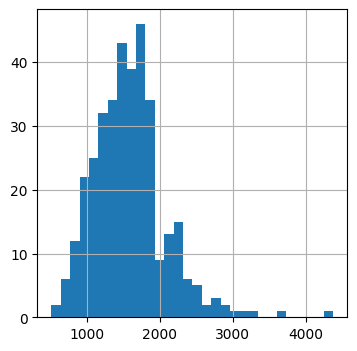

In [9326]:
team_score_0 = pd.DataFrame(team_point.groupby('team_id')['score'].sum())
team_point.groupby('team_id')['score'].sum().hist(bins=30, figsize = (4,4))

In [9327]:
team_score_0.describe()

,score
count,355.00
mean,"1,585.49"
std,496.25
min,516.00
25%,"1,251.00"
50%,"1,554.00"
75%,"1,817.00"
max,"4,376.00"


array([[<AxesSubplot:title={'center':'score'}>]], dtype=object)

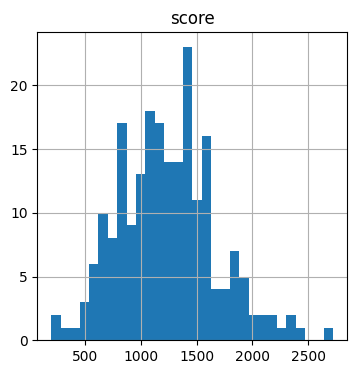

In [9328]:
team_score = pd.DataFrame(team.groupby('team_id')['score'].sum())
team_score.hist(bins=30, figsize = (4,4))


In [9329]:
team_score.describe()

,score
count,214.00
mean,"1,240.01"
std,428.67
min,200.00
25%,934.50
50%,"1,236.00"
75%,"1,483.50"
max,"2,724.00"


После сокращения числа периодов распределение score изменилось незначительно

In [9330]:
print(team_score.index.nunique())

214


In [9331]:
team_game = user.drop('user_id', axis=1).drop_duplicates()

In [9332]:
team_game.nunique()

team_id    214
game_id     43
dtype: int64

**Анализ величины score команд по разным играм**

In [9333]:
team = team.set_index('team_id').join(team_game.set_index('team_id')).reset_index()

In [9334]:
team.head(1)

,team_id,category_id,period,score,place,game_id
0,1248,5,2,24,1,182


In [9335]:
team['total_score']=team.groupby('team_id')['score'].transform('sum')

In [9336]:
team.head(1)

,team_id,category_id,period,score,place,game_id,total_score
0,1248,5,2,24,1,182,2382


In [9337]:
team = team.set_index('team_id').join(user.drop('game_id', axis=1).set_index('team_id'), how = 'right').reset_index()

In [9338]:
team.head(1)

,team_id,category_id,period,score,place,game_id,total_score,user_id
0,1248,5,2,24,1,182,2382,10273


In [9339]:
for i in [1, 2, 3, 4, 5, 6]:
    col_name = 'cat_'+ str(i)
    team[col_name] = team[team['category_id'] == i].groupby(['user_id'])['score'].transform('sum')

In [9340]:
team.head()

,team_id,category_id,period,score,place,game_id,total_score,user_id,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6
0,1248,5,2,24,1,182,2382,10273,NaN,NaN,NaN,NaN,125.00,NaN
1,1248,4,2,44,1,182,2382,10273,NaN,NaN,NaN,208.00,NaN,NaN
2,1248,1,4,68,1,182,2382,10273,174.00,NaN,NaN,NaN,NaN,NaN
3,1248,6,4,354,1,182,2382,10273,NaN,NaN,NaN,NaN,NaN,"1,191.00"
4,1248,6,1,261,1,182,2382,10273,NaN,NaN,NaN,NaN,NaN,"1,191.00"


In [9341]:
team.shape

(23352, 14)

In [9342]:
team = team.groupby('user_id').max()

In [9343]:
team.head()

,team_id,category_id,period,score,place,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6
user_id,,,,,,,,,,,,,
10001,1366,6,4,328,5,192,2092,179.00,131.00,421.00,156.00,159.00,"1,046.00"
10002,1682,6,4,299,6,236,1978,145.00,208.00,382.00,173.00,81.00,989.00
10003,1652,6,4,110,6,234,428,-71.00,-151.00,209.00,74.00,153.00,214.00
10004,1472,6,4,142,6,206,778,-25.00,-25.00,224.00,80.00,135.00,389.00
10005,1602,6,4,114,6,219,584,-46.00,-80.00,216.00,90.00,112.00,292.00


In [9344]:
team.shape

(973, 13)

In [9345]:
team_game_score = team.drop(['category_id','period','score','place'], axis=1).drop_duplicates()

In [9346]:
team_game_score.head(1)

,team_id,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6
user_id,,,,,,,,,
10001,1366,192,2092,179.00,131.00,421.00,156.00,159.00,"1,046.00"


In [9347]:
team_game_score['total_score'].describe()

count     214.00
mean    1,240.01
std       428.67
min       200.00
25%       934.50
50%     1,236.00
75%     1,483.50
max     2,724.00
Name: total_score, dtype: float64

In [9348]:
min_score_game = team_game_score.groupby('game_id')['total_score'].min()
max_score_game = team_game_score.groupby('game_id')['total_score'].max()
mean_score_game = team_game_score.groupby('game_id')['total_score'].mean()

In [9349]:
min_score_game.describe()

count      43.00
mean      806.19
std       320.05
min       200.00
25%       607.00
50%       756.00
75%       943.00
max     1,568.00
Name: total_score, dtype: float64

Text(0, 0.5, '')

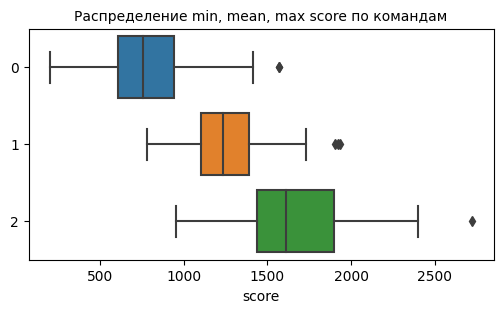

In [9350]:
plt.figure(figsize = (6,3))
sns.boxplot(data=[min_score_game, mean_score_game, max_score_game],
                 orient="h")
plt.title('Распределение min, mean, max score по командам', fontsize = 10)
plt.xlabel('score')
plt.ylabel('')

In [9351]:
user_score = team_game_score.set_index('team_id').join(user.set_index('team_id').drop('game_id', axis=1), how = 'right')

In [9352]:
user_score.head(1)

,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,user_id
team_id,,,,,,,,,
1248,182,2382,174.00,281.00,403.00,208.00,125.00,"1,191.00",10273


In [9353]:
user_score['max_score']=user_score.groupby('game_id')['total_score'].transform('max')
user_score.head(5)

,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,user_id,max_score
team_id,,,,,,,,,,
1248,182,2382,174.00,281.00,403.00,208.00,125.00,"1,191.00",10273,2382
1248,182,2382,174.00,281.00,403.00,208.00,125.00,"1,191.00",10762,2382
1248,182,2382,174.00,281.00,403.00,208.00,125.00,"1,191.00",10646,2382
1252,182,996,-5.00,11.00,302.00,125.00,65.00,498.00,10547,2382
1252,182,996,-5.00,11.00,302.00,125.00,65.00,498.00,10833,2382


In [9354]:
user_score['score_rating']= user_score['total_score']/user_score['max_score']
user_score.head(1)

,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,user_id,max_score,score_rating
team_id,,,,,,,,,,,
1248,182,2382,174.00,281.00,403.00,208.00,125.00,"1,191.00",10273,2382,1.00


In [9355]:
for i in [1, 2, 3, 4, 5, 6]:
    col_name = 'rating_'+ str(i)+'_max'
    col_name_cat = 'cat_'+str(i)
    user_score[col_name] = user_score.groupby('game_id')[col_name_cat].transform('max')

In [9356]:
user_score.head(5)

,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,user_id,max_score,score_rating,rating_1_max,rating_2_max,rating_3_max,rating_4_max,rating_5_max,rating_6_max
team_id,,,,,,,,,,,,,,,,,
1248,182,2382,174.00,281.00,403.00,208.00,125.00,"1,191.00",10273,2382,1.00,174.00,281.00,403.00,208.00,125.00,"1,191.00"
1248,182,2382,174.00,281.00,403.00,208.00,125.00,"1,191.00",10762,2382,1.00,174.00,281.00,403.00,208.00,125.00,"1,191.00"
1248,182,2382,174.00,281.00,403.00,208.00,125.00,"1,191.00",10646,2382,1.00,174.00,281.00,403.00,208.00,125.00,"1,191.00"
1252,182,996,-5.00,11.00,302.00,125.00,65.00,498.00,10547,2382,0.42,174.00,281.00,403.00,208.00,125.00,"1,191.00"
1252,182,996,-5.00,11.00,302.00,125.00,65.00,498.00,10833,2382,0.42,174.00,281.00,403.00,208.00,125.00,"1,191.00"


In [9357]:
for i in [1, 2, 3, 4, 5, 6]:
    col_name = 'rating_'+ str(i)+'_max'
    col_name_cat = 'cat_'+str(i)
    col_name_rating = 'rating_'+str(i)
    user_score[col_name_rating] = user_score[col_name_cat] / user_score[col_name]

In [9358]:
user_score.head(5)

,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,user_id,max_score,...,rating_3_max,rating_4_max,rating_5_max,rating_6_max,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6
team_id,,,,,,,,,,,,,,,,,,,,,
1248,182,2382,174.00,281.00,403.00,208.00,125.00,"1,191.00",10273,2382,...,403.00,208.00,125.00,"1,191.00",1.00,1.00,1.00,1.00,1.00,1.00
1248,182,2382,174.00,281.00,403.00,208.00,125.00,"1,191.00",10762,2382,...,403.00,208.00,125.00,"1,191.00",1.00,1.00,1.00,1.00,1.00,1.00
1248,182,2382,174.00,281.00,403.00,208.00,125.00,"1,191.00",10646,2382,...,403.00,208.00,125.00,"1,191.00",1.00,1.00,1.00,1.00,1.00,1.00
1252,182,996,-5.00,11.00,302.00,125.00,65.00,498.00,10547,2382,...,403.00,208.00,125.00,"1,191.00",-0.03,0.04,0.75,0.60,0.52,0.42
1252,182,996,-5.00,11.00,302.00,125.00,65.00,498.00,10833,2382,...,403.00,208.00,125.00,"1,191.00",-0.03,0.04,0.75,0.60,0.52,0.42


In [9359]:
user_score.columns

Index(['game_id', 'total_score', 'cat_1', 'cat_2', 'cat_3', 'cat_4', 'cat_5',
       'cat_6', 'user_id', 'max_score', 'score_rating', 'rating_1_max',
       'rating_2_max', 'rating_3_max', 'rating_4_max', 'rating_5_max',
       'rating_6_max', 'rating_1', 'rating_2', 'rating_3', 'rating_4',
       'rating_5', 'rating_6'],
      dtype='object')

In [9360]:
col_drop = ['max_score', 'rating_1_max', 'rating_2_max', 'rating_3_max', 'rating_4_max', 'rating_5_max', 'rating_6_max']

In [9361]:
user_score = user_score.drop(col_drop, axis=1).set_index('user_id')

In [9362]:
user_score.head(5)

,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6
user_id,,,,,,,,,,,,,,,
10273,182,2382,174.00,281.00,403.00,208.00,125.00,"1,191.00",1.00,1.00,1.00,1.00,1.00,1.00,1.00
10762,182,2382,174.00,281.00,403.00,208.00,125.00,"1,191.00",1.00,1.00,1.00,1.00,1.00,1.00,1.00
10646,182,2382,174.00,281.00,403.00,208.00,125.00,"1,191.00",1.00,1.00,1.00,1.00,1.00,1.00,1.00
10547,182,996,-5.00,11.00,302.00,125.00,65.00,498.00,0.42,-0.03,0.04,0.75,0.60,0.52,0.42
10833,182,996,-5.00,11.00,302.00,125.00,65.00,498.00,0.42,-0.03,0.04,0.75,0.60,0.52,0.42


In [9363]:
df.head(1)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10884,4.00,4.00,4.00,4.00


In [9364]:
df_score = df.set_index('id').join(user_score, how = 'left')

In [9365]:
df_score.head()

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6
id,,,,,,,,,,,,,,,,,,,
10884,4.00,4.00,4.00,4.00,202,872,-9.00,-41.00,288.00,101.00,97.00,436.00,0.48,-0.08,-0.23,0.71,0.70,1.00,0.48
10106,5.00,4.00,5.00,5.00,211,1512,50.00,104.00,364.00,133.00,105.00,756.00,1.00,1.00,0.88,0.98,0.88,1.00,1.00
10438,6.00,5.00,5.00,5.00,242,1288,51.00,44.00,280.00,131.00,138.00,644.00,1.00,1.00,0.62,0.98,1.00,0.80,1.00
10130,5.00,4.00,5.00,5.00,184,1018,27.00,8.00,263.00,112.00,99.00,509.00,0.56,0.28,0.04,0.64,0.65,1.00,0.56
10667,4.00,5.00,5.00,5.00,193,1440,67.00,54.00,313.00,139.00,147.00,720.00,0.67,0.40,0.22,0.96,0.77,0.86,0.67


In [9366]:
df_score.drop('game_id', axis=1).corr()

,Analytical thinking,Systemic thinking,Adaptability,Focus,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6
Analytical thinking,1.00,0.56,0.55,0.54,0.16,0.15,0.18,0.10,0.16,-0.04,0.16,0.16,0.09,0.16,0.09,0.17,-0.01,0.16
Systemic thinking,0.56,1.00,0.48,0.49,0.19,0.17,0.20,0.12,0.19,-0.05,0.19,0.16,0.06,0.14,0.08,0.15,0.02,0.16
Adaptability,0.55,0.48,1.00,0.59,0.11,0.11,0.13,0.05,0.11,-0.00,0.11,0.11,0.09,0.12,-0.00,0.13,0.05,0.11
Focus,0.54,0.49,0.59,1.00,0.08,0.07,0.09,0.06,0.08,-0.01,0.08,0.11,0.02,0.06,0.06,0.12,0.06,0.11
total_score,0.16,0.19,0.11,0.08,1.00,0.96,0.97,0.75,0.92,0.02,1.00,0.79,0.24,0.65,0.55,0.68,0.18,0.79
cat_1,0.15,0.17,0.11,0.07,0.96,1.00,0.93,0.65,0.86,0.06,0.96,0.71,0.25,0.60,0.46,0.60,0.20,0.71
cat_2,0.18,0.20,0.13,0.09,0.97,0.93,1.00,0.64,0.89,-0.04,0.97,0.80,0.24,0.68,0.46,0.69,0.15,0.80
cat_3,0.10,0.12,0.05,0.06,0.75,0.65,0.64,1.00,0.61,-0.40,0.75,0.58,0.15,0.43,0.73,0.43,-0.17,0.58
cat_4,0.16,0.19,0.11,0.08,0.92,0.86,0.89,0.61,1.00,0.03,0.92,0.71,0.21,0.57,0.42,0.75,0.22,0.71
cat_5,-0.04,-0.05,-0.00,-0.01,0.02,0.06,-0.04,-0.40,0.03,1.00,0.02,0.04,0.05,-0.01,-0.18,0.07,0.66,0.04


In [9367]:
df_score.columns

Index(['Analytical thinking', 'Systemic thinking', 'Adaptability', 'Focus',
       'game_id', 'total_score', 'cat_1', 'cat_2', 'cat_3', 'cat_4', 'cat_5',
       'cat_6', 'score_rating', 'rating_1', 'rating_2', 'rating_3', 'rating_4',
       'rating_5', 'rating_6'],
      dtype='object')

In [9368]:
col_drop = ['total_score', 'game_id','cat_1','cat_2','cat_3','cat_4','cat_5','cat_6', 'score_rating', 'rating_1', 'rating_2', 'rating_3', 'rating_4',
       'rating_5', 'rating_6']

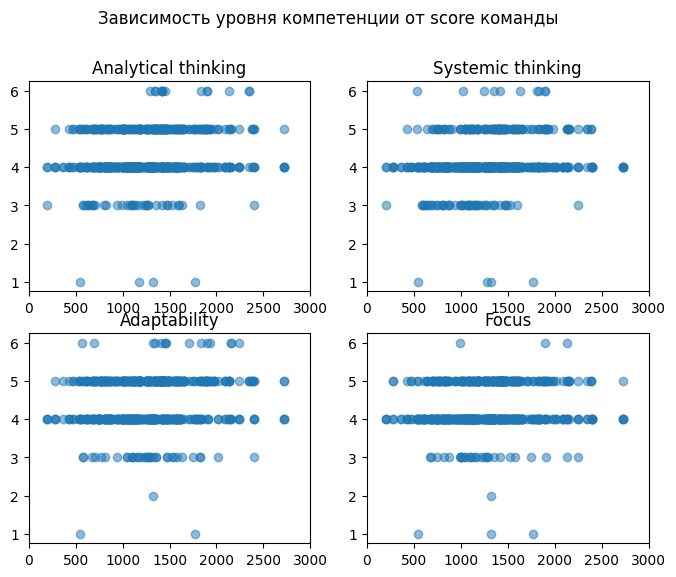

In [9369]:
fig, axes = plt.subplots(nrows = 2, ncols =2 )

fig .set_size_inches(8, 6)

name_score = df_score.drop(col_drop, axis = 1).columns.unique()

for k in range(len(name_score)):
    i = np.floor(k/2)
    i = i.astype(int)
    j = k - i*2
    j = j.astype(int)
        
    axes[i,j].set(title=name_score[k])
       
    axes[i,j].set_xlim(0,3000) #сделаем одну шкалу
   
    axes[i,j].set_yticks([1, 2, 3, 4, 5, 6])
    axes[i,j].scatter(x=df_score['total_score'], y = df_score[name_score[k]], alpha=0.5)
    
plt.suptitle('Зависимость уровня компетенции от score команды', x=0.5, y=1)
plt.show()

Преобразуем score  в места

In [9370]:
df_score = df.set_index('id').join(user_score, how = 'left')

In [9371]:
df_score.head()

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6
id,,,,,,,,,,,,,,,,,,,
10884,4.00,4.00,4.00,4.00,202,872,-9.00,-41.00,288.00,101.00,97.00,436.00,0.48,-0.08,-0.23,0.71,0.70,1.00,0.48
10106,5.00,4.00,5.00,5.00,211,1512,50.00,104.00,364.00,133.00,105.00,756.00,1.00,1.00,0.88,0.98,0.88,1.00,1.00
10438,6.00,5.00,5.00,5.00,242,1288,51.00,44.00,280.00,131.00,138.00,644.00,1.00,1.00,0.62,0.98,1.00,0.80,1.00
10130,5.00,4.00,5.00,5.00,184,1018,27.00,8.00,263.00,112.00,99.00,509.00,0.56,0.28,0.04,0.64,0.65,1.00,0.56
10667,4.00,5.00,5.00,5.00,193,1440,67.00,54.00,313.00,139.00,147.00,720.00,0.67,0.40,0.22,0.96,0.77,0.86,0.67


In [9372]:
df_score.drop(['game_id'], axis=1).corr()

,Analytical thinking,Systemic thinking,Adaptability,Focus,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6
Analytical thinking,1.00,0.56,0.55,0.54,0.16,0.15,0.18,0.10,0.16,-0.04,0.16,0.16,0.09,0.16,0.09,0.17,-0.01,0.16
Systemic thinking,0.56,1.00,0.48,0.49,0.19,0.17,0.20,0.12,0.19,-0.05,0.19,0.16,0.06,0.14,0.08,0.15,0.02,0.16
Adaptability,0.55,0.48,1.00,0.59,0.11,0.11,0.13,0.05,0.11,-0.00,0.11,0.11,0.09,0.12,-0.00,0.13,0.05,0.11
Focus,0.54,0.49,0.59,1.00,0.08,0.07,0.09,0.06,0.08,-0.01,0.08,0.11,0.02,0.06,0.06,0.12,0.06,0.11
total_score,0.16,0.19,0.11,0.08,1.00,0.96,0.97,0.75,0.92,0.02,1.00,0.79,0.24,0.65,0.55,0.68,0.18,0.79
cat_1,0.15,0.17,0.11,0.07,0.96,1.00,0.93,0.65,0.86,0.06,0.96,0.71,0.25,0.60,0.46,0.60,0.20,0.71
cat_2,0.18,0.20,0.13,0.09,0.97,0.93,1.00,0.64,0.89,-0.04,0.97,0.80,0.24,0.68,0.46,0.69,0.15,0.80
cat_3,0.10,0.12,0.05,0.06,0.75,0.65,0.64,1.00,0.61,-0.40,0.75,0.58,0.15,0.43,0.73,0.43,-0.17,0.58
cat_4,0.16,0.19,0.11,0.08,0.92,0.86,0.89,0.61,1.00,0.03,0.92,0.71,0.21,0.57,0.42,0.75,0.22,0.71
cat_5,-0.04,-0.05,-0.00,-0.01,0.02,0.06,-0.04,-0.40,0.03,1.00,0.02,0.04,0.05,-0.01,-0.18,0.07,0.66,0.04


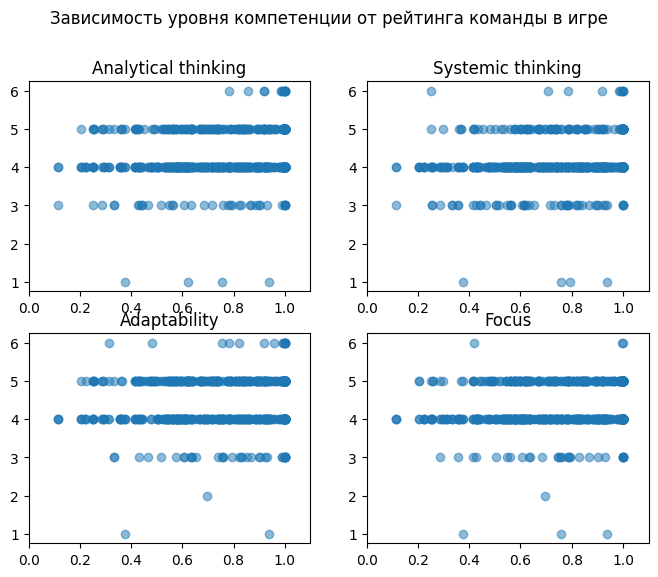

In [9373]:
fig, axes = plt.subplots(nrows = 2, ncols =2 )

fig .set_size_inches(8, 6)

name_score = df_score.drop(col_drop, axis = 1).columns.unique()

for k in range(len(name_score)):
    i = np.floor(k/2)
    i = i.astype(int)
    j = k - i*2
    j = j.astype(int)
        
    axes[i,j].set(title=name_score[k])
       
    axes[i,j].set_xlim(0,1.1) #сделаем одну шкалу
   
    axes[i,j].set_yticks([1, 2, 3, 4, 5, 6])
    axes[i,j].scatter(x=df_score['score_rating'], y = df_score[name_score[k]], alpha=0.5)
    
plt.suptitle('Зависимость уровня компетенции от рейтинга команды в игре', x=0.5, y=1)
plt.show()

**Распределение таргета**

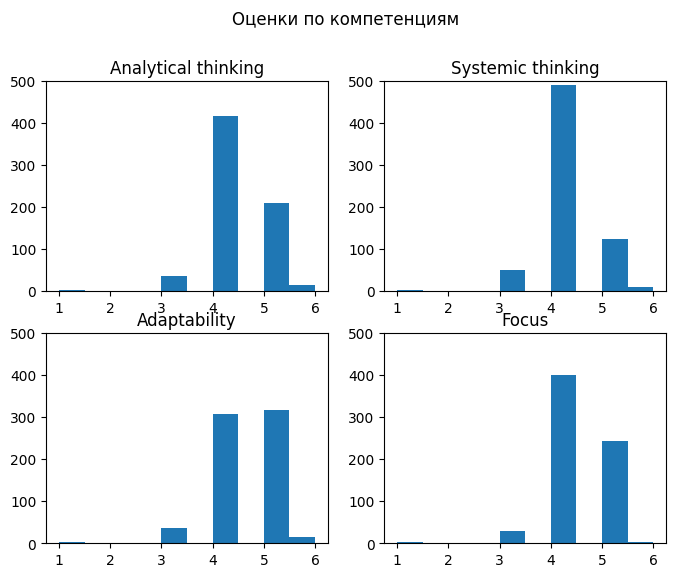

In [9374]:
fig, axes = plt.subplots(nrows = 2, ncols =2 )

fig .set_size_inches(8, 6)

name_score = df.drop('id', axis = 1).columns.unique()

for k in range(len(name_score)):
    i = np.floor(k/2)
    i = i.astype(int)
    j = k - i*2
    j = j.astype(int)
        
    axes[i,j].set(title=name_score[k])
       
    axes[i,j].set_ylim(0,500) #сделаем одну шкалу
   
    axes[i,j].set_xticks([1, 2, 3, 4, 5, 6])
    axes[i,j].hist(df[name_score[k]])
    
plt.suptitle('Оценки по компетенциям', x=0.5, y=1)
plt.show()

## Подготовка модели. Модель OHE-решений

In [9375]:
user_decision['decision_id'].describe()

count   60,228.00
mean       210.20
std        130.66
min          1.00
25%         92.00
50%        181.00
75%        326.00
max        437.00
Name: decision_id, dtype: float64

In [9376]:
user_decision.head()

,user_id,period,decision_id
0,10625,1,409
1,10318,3,203
2,10775,4,420
3,10236,2,284
4,10130,3,72


In [9377]:
ud = user_decision

In [9378]:
ud = ud.set_index('decision_id').join(decision.set_index('decision_id'), on = 'decision_id', how = 'left').reset_index()

In [9379]:
ud.head()

,decision_id,user_id,period,decision_name
0,409,10625,1,Sending Engineers on training courses
1,203,10318,3,"Sell overdue 30>d accounts receivable, which a..."
2,420,10775,4,Quality of the purchased materials Packing mat...
3,284,10236,2,Improvement of the technology of entrance control
4,72,10130,3,Education of the dealersвЂ™ sales staff


In [9380]:
ud.shape

(60228, 4)

In [9381]:
for col in range(1, 439):
    col_name = str(col)
    ud[col_name] = col
    

In [9382]:
def ohe(col_name):
    if col_name == number_decision:
        return 1
    else:
        return 0

In [9383]:
for col in range(1, 439):
    col_name = str(col)
    number_decision = col
    ud[col_name] = ud['decision_id'].apply(ohe)

In [9384]:
ud.isna().sum()

decision_id      0
user_id          0
period           0
decision_name    0
1                0
                ..
434              0
435              0
436              0
437              0
438              0
Length: 442, dtype: int64

In [9385]:
ud.shape

(60228, 442)

In [9386]:
ud.tail()

,decision_id,user_id,period,decision_name,1,2,3,4,5,6,...,429,430,431,432,433,434,435,436,437,438
60223,329,10312,3,Increase in energy efficiency of equipment,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60224,33,10189,1,[Ltd вЂњAdvrt AgencyвЂќ] Audit of companyвЂ™s ...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60225,123,10346,3,Hiring engineers among university graduates,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60226,140,10424,2,Bonuses for innovation and rationalization of ...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60227,405,10050,3,Managers salary,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9387]:
df_1 = df.set_index('id').join(ud.set_index('user_id'), how = 'left').reset_index()

In [9388]:
df_1.head(3)

,index,Analytical thinking,Systemic thinking,Adaptability,Focus,decision_id,period,decision_name,1,2,...,429,430,431,432,433,434,435,436,437,438
0,10001,4.00,4.00,5.00,4.00,126,4,Engineers qualification,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10001,4.00,4.00,5.00,4.00,175,3,Evaluation of the characteristic Moral qualiti...,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10001,4.00,4.00,5.00,4.00,165,3,Sending staff on short-term courses of time ma...,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9389]:
df_1 = df_1.groupby('index').max()

In [9390]:
df_1 = df_1.drop(['decision_id','period','decision_name'], axis=1)
df_1.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,1,2,3,4,5,6,...,429,430,431,432,433,434,435,436,437,438
index,,,,,,,,,,,,,,,,,,,,,
10001,4.00,4.00,5.00,4.00,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


**Подбор весов для индивидуальных решений**

In [9391]:
df_2 = df_1
df_3 = df_1
df_4 = df_1

**Analytical thinking**

In [9392]:
list_dec_1 = []
for i in range(1, 438):
    cor = df_1['Analytical thinking'].corr(df_1[str(i)]) ** 2
    list_dec_1.append({'i': i, 
                   'corr' : cor})
list_dec_1 = pd.DataFrame(list_dec_1).set_index('i')
list_dec_1['corr'] = list_dec_1['corr'].fillna(0)

In [9393]:
for i in range(1, 438):
    if i in list_dec_1.index:
        corr = list_dec_1['corr'].loc[i]
        df_1[str(i)] = df_1[str(i)] * corr  
    else:
        continue    

**Systemic thinking**

In [9394]:
list_dec_2 = []
for i in range(1, 438):
    cor = df_2['Systemic thinking'].corr(df_2[str(i)]) ** 2
    list_dec_2.append({'i': i, 
                   'corr' : cor})
list_dec_2 = pd.DataFrame(list_dec_2).set_index('i')
list_dec_2['corr'] = list_dec_2['corr'].fillna(0)

In [9395]:
for i in range(1, 438):
    if i in list_dec_2.index:
        corr = list_dec_2['corr'].loc[i]
        df_2[str(i)] = df_2[str(i)] * corr  
    else:
        continue    

**Adaptability**

In [9396]:
list_dec_3 = []
for i in range(1, 438):
    cor = df_3['Adaptability'].corr(df_3[str(i)]) ** 2
    list_dec_3.append({'i': i, 
                   'corr' : cor})
list_dec_3 = pd.DataFrame(list_dec_3).set_index('i')
list_dec_3['corr'] = list_dec_3['corr'].fillna(0)

In [9397]:
for i in range(1, 438):
    if i in list_dec_3.index:
        corr = list_dec_3['corr'].loc[i]
        df_3[str(i)] = df_3[str(i)] * corr  
    else:
        continue    

**Focus**

In [9398]:
list_dec_4 = []
for i in range(1, 438):
    cor = df_4['Focus'].corr(df_4[str(i)]) ** 2
    list_dec_4.append({'i': i, 
                   'corr' : cor})
list_dec_4 = pd.DataFrame(list_dec_4).set_index('i')
list_dec_4['corr'] = list_dec_4['corr'].fillna(0)

In [9399]:
for i in range(1, 438):
    if i in list_dec_4.index:
        corr = list_dec_4['corr'].loc[i]
        df_4[str(i)] = df_4[str(i)] * corr  
    else:
        continue    

In [9400]:
df_1.head()

,Analytical thinking,Systemic thinking,Adaptability,Focus,1,2,3,4,5,6,...,429,430,431,432,433,434,435,436,437,438
index,,,,,,,,,,,,,,,,,,,,,
10001,4.00,4.00,5.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
10003,5.00,5.00,5.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
10004,4.00,4.00,5.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
10006,4.00,4.00,5.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
10008,5.00,4.00,5.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


In [9401]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability', 'Focus']

In [9402]:
df_1['total'] = df_1.drop(col_drop, axis=1).sum(axis=1)

In [9403]:
df_1.shape

(680, 443)

## 'Analytical thinking' (в трейне: ОНЕ-решений, баллы и рейтинги)

In [9404]:
df_score.head()

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6
id,,,,,,,,,,,,,,,,,,,
10884,4.00,4.00,4.00,4.00,202,872,-9.00,-41.00,288.00,101.00,97.00,436.00,0.48,-0.08,-0.23,0.71,0.70,1.00,0.48
10106,5.00,4.00,5.00,5.00,211,1512,50.00,104.00,364.00,133.00,105.00,756.00,1.00,1.00,0.88,0.98,0.88,1.00,1.00
10438,6.00,5.00,5.00,5.00,242,1288,51.00,44.00,280.00,131.00,138.00,644.00,1.00,1.00,0.62,0.98,1.00,0.80,1.00
10130,5.00,4.00,5.00,5.00,184,1018,27.00,8.00,263.00,112.00,99.00,509.00,0.56,0.28,0.04,0.64,0.65,1.00,0.56
10667,4.00,5.00,5.00,5.00,193,1440,67.00,54.00,313.00,139.00,147.00,720.00,0.67,0.40,0.22,0.96,0.77,0.86,0.67


In [9405]:
df_1.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,1,2,3,4,5,6,...,430,431,432,433,434,435,436,437,438,total
index,,,,,,,,,,,,,,,,,,,,,
10001,4.00,4.00,5.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00


In [9406]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability','Focus']

In [9407]:
df_7 = df_score.join(df_1.drop(col_drop, axis=1))

In [9408]:
df_7.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,...,430,431,432,433,434,435,436,437,438,total
id,,,,,,,,,,,,,,,,,,,,,
10884,4.00,4.00,4.00,4.00,202,872,-9.00,-41.00,288.00,101.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00


In [9409]:
df_7['max_total'] = df_7.groupby('game_id')['total'].transform('max')

In [9410]:
df_7['rating_user'] = df_7['total'] / df_7['max_total']

In [9411]:
df_7 = df_7[df_7['Analytical thinking']>2]
df_7 = df_7[df_7['Systemic thinking']>2]
df_7 = df_7[df_7['Adaptability']>2]
df_7 = df_7[df_7['Focus']>2]
df_7.shape

(674, 460)

In [9412]:
for i in range(1, 439):
    df_7 = df_7.drop(str(i), axis=1)    

In [9413]:
df_7.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,...,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,total,max_total,rating_user
id,,,,,,,,,,,,,,,,,,,,,
10884,4.00,4.00,4.00,4.00,202,872,-9.00,-41.00,288.00,101.00,...,0.48,-0.08,-0.23,0.71,0.70,1.00,0.48,0.00,0.00,0.39


In [9414]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability', 
            'Focus', 'max_total']

In [9415]:
X_train, X_test, y_train, y_test = train_test_split(
    df_7.drop(col_drop, axis=1), df_7['Analytical thinking'], stratify = df_7['Analytical thinking'], test_size=0.25, random_state=12345)

In [9416]:
print(X_train.shape)
print(y_train.shape)

(505, 17)
(505,)


In [9417]:
X_train.head()

,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,total,rating_user
id,,,,,,,,,,,,,,,,,
10732,252,1774,82.00,158.00,384.00,170.00,93.00,887.00,0.94,0.80,0.71,1.00,0.99,1.00,0.94,0.00,0.03
10804,244,1814,110.00,237.00,234.00,174.00,152.00,907.00,1.00,1.00,1.00,0.67,1.00,1.00,1.00,0.00,0.74
10508,252,1176,35.00,35.00,337.00,102.00,79.00,588.00,0.62,0.34,0.16,0.88,0.60,0.85,0.62,0.00,0.97
10219,244,966,-7.00,-1.00,250.00,122.00,119.00,483.00,0.53,-0.06,-0.00,0.72,0.70,0.78,0.53,0.00,0.02
10426,182,872,-13.00,-37.00,340.00,97.00,49.00,436.00,0.37,-0.07,-0.13,0.84,0.47,0.39,0.37,0.00,0.75


In [9418]:
scaler_1 = StandardScaler()
scaler_1.fit(X_train)
X_train = scaler_1.transform(X_train)
X_test = scaler_1.transform(X_test)

**LogReg**

In [9419]:
model = LogisticRegression()

In [9420]:
parametrs = { 'penalty': ['l1', 'l2', 'elasticnet'],
              'fit_intercept': [True, False] }

In [9421]:
%%time
model = GridSearchCV(model, parametrs, cv=5)
model.fit(X_train, y_train)
model.best_params_

CPU times: total: 234 ms
Wall time: 232 ms


{'fit_intercept': True, 'penalty': 'l2'}

In [9422]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [9423]:
f1_score(y_train, pred_train, average='macro', zero_division = 0)

0.2903869821628454

In [9424]:
scores = cross_val_score(model, X_train, y_train, cv=5)
scores

array([0.62376238, 0.51485149, 0.68316832, 0.61386139, 0.61386139])

In [9425]:
f1_score(y_test, pred_test, average='macro', zero_division = 0)

0.29551204209674153

In [9426]:
r_s = recall_score(y_test, pred_test, average = 'macro', zero_division = 0)
r_s

0.30528846153846156

In [9427]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         9
         4.0       0.66      0.89      0.76       104
         5.0       0.59      0.33      0.42        52
         6.0       0.00      0.00      0.00         4

    accuracy                           0.65       169
   macro avg       0.31      0.31      0.30       169
weighted avg       0.59      0.65      0.60       169



In [9428]:
total_score_1 = []
total_score_1.append({      'model': 'log_reg',
                           'recall': r_s})
pd.DataFrame(total_score_1)

,model,recall
0,log_reg,0.31


**RFC**

In [9429]:
clf = RandomForestClassifier(random_state=12345)


In [9430]:
parametrs = { 'max_depth': [6, 12, 15, 20],
              'n_estimators': [10, 20, 50, 100],
            'min_samples_leaf': [10, 20, 30]}

In [9431]:
%%time
clf = GridSearchCV(clf, parametrs, cv=5)
clf.fit(X_train, y_train)
clf.best_params_

CPU times: total: 12.8 s
Wall time: 12.8 s


{'max_depth': 6, 'min_samples_leaf': 10, 'n_estimators': 20}

In [9432]:
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

In [9433]:
f1_score(y_train, pred_train, average='macro', zero_division = 0)

0.3438912438912439

In [9434]:
f1_score(y_test, pred_test, average='macro', zero_division = 0)

0.27666666666666667

In [9435]:
r_s = recall_score(y_test, pred_test, average = 'macro', zero_division = 0)
r_s

0.2908653846153846

In [9436]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         9
         4.0       0.65      0.91      0.76       104
         5.0       0.57      0.25      0.35        52
         6.0       0.00      0.00      0.00         4

    accuracy                           0.64       169
   macro avg       0.30      0.29      0.28       169
weighted avg       0.57      0.64      0.57       169



In [9437]:
total_score_1.append({
                           'model': 'RFC',
                           'recall': r_s})
pd.DataFrame(total_score_1)

,model,recall
0,log_reg,0.31
1,RFC,0.29


**LGBM**

In [9438]:
lgbm = LGBMClassifier()

In [9439]:
parameters_lgbm = {'max_depth': [3, 6, 12],
                  'learning_rate':[0.001, 0.003, 0.005, 0.01]}

In [9440]:
lgbm = GridSearchCV(lgbm, parameters_lgbm)

In [9441]:
%%time
lgbm.fit(X_train, y_train)

CPU times: total: 26.1 s
Wall time: 3.37 s


GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.001, 0.003, 0.005, 0.01],
                         'max_depth': [3, 6, 12]})

In [9442]:
lgbm.best_params_

{'learning_rate': 0.005, 'max_depth': 3}

In [9443]:
pred_train = lgbm.predict(X_train)
pred_test = lgbm.predict(X_test)

In [9444]:
f1_score(y_train, pred_train, average='macro', zero_division = 0)

0.2540306915306915

In [9445]:
f1_score(y_test, pred_test, average='macro', zero_division = 0)

0.21687330492057344

In [9446]:
r_s = recall_score(y_test, pred_test, average = 'macro', zero_division = 0)
r_s

0.2596153846153846

In [9447]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         9
         4.0       0.63      0.98      0.76       104
         5.0       0.50      0.06      0.10        52
         6.0       0.00      0.00      0.00         4

    accuracy                           0.62       169
   macro avg       0.28      0.26      0.22       169
weighted avg       0.54      0.62      0.50       169



In [9448]:
total_score_1.append({
                           'model': 'LGBM',
                           'recall': r_s})
pd.DataFrame(total_score_1)

,model,recall
0,log_reg,0.31
1,RFC,0.29
2,LGBM,0.26


In [9449]:
X_train = df_7.drop(col_drop, axis=1) 
y_train = df_7['Analytical thinking']
model.fit(X_train, y_train)
model_1 = model

## 'Systemic thinking' (в трейне: ОНЕ-решений, баллы и рейтинги)

In [9450]:
df_score.head()

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6
id,,,,,,,,,,,,,,,,,,,
10884,4.00,4.00,4.00,4.00,202,872,-9.00,-41.00,288.00,101.00,97.00,436.00,0.48,-0.08,-0.23,0.71,0.70,1.00,0.48
10106,5.00,4.00,5.00,5.00,211,1512,50.00,104.00,364.00,133.00,105.00,756.00,1.00,1.00,0.88,0.98,0.88,1.00,1.00
10438,6.00,5.00,5.00,5.00,242,1288,51.00,44.00,280.00,131.00,138.00,644.00,1.00,1.00,0.62,0.98,1.00,0.80,1.00
10130,5.00,4.00,5.00,5.00,184,1018,27.00,8.00,263.00,112.00,99.00,509.00,0.56,0.28,0.04,0.64,0.65,1.00,0.56
10667,4.00,5.00,5.00,5.00,193,1440,67.00,54.00,313.00,139.00,147.00,720.00,0.67,0.40,0.22,0.96,0.77,0.86,0.67


In [9451]:
df_2.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,1,2,3,4,5,6,...,430,431,432,433,434,435,436,437,438,total
index,,,,,,,,,,,,,,,,,,,,,
10001,4.00,4.00,5.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00


In [9452]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability','Focus']

In [9453]:
df_7 = df_score.join(df_2.drop(col_drop, axis=1))

In [9454]:
df_7.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,...,430,431,432,433,434,435,436,437,438,total
id,,,,,,,,,,,,,,,,,,,,,
10884,4.00,4.00,4.00,4.00,202,872,-9.00,-41.00,288.00,101.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00


In [9455]:
df_7['max_total'] = df_7.groupby('game_id')['total'].transform('max')

In [9456]:
df_7['rating_user'] = df_7['total'] / df_7['max_total']

In [9457]:
df_7 = df_7[df_7['Analytical thinking']>2]
df_7 = df_7[df_7['Systemic thinking']>2]
df_7 = df_7[df_7['Adaptability']>2]
df_7 = df_7[df_7['Focus']>2]
df_7.shape

(674, 460)

In [9458]:
for i in range(1, 439):
    df_7 = df_7.drop(str(i), axis=1)    

In [9459]:
df_7.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,...,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,total,max_total,rating_user
id,,,,,,,,,,,,,,,,,,,,,
10884,4.00,4.00,4.00,4.00,202,872,-9.00,-41.00,288.00,101.00,...,0.48,-0.08,-0.23,0.71,0.70,1.00,0.48,0.00,0.00,0.39


In [9460]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability', 
            'Focus', 'max_total']

In [9461]:
X_train, X_test, y_train, y_test = train_test_split(
    df_7.drop(col_drop, axis=1), df_7['Systemic thinking'], stratify = df_7['Systemic thinking'], test_size=0.25, random_state=12345)

In [9462]:
print(X_train.shape)
print(y_train.shape)

(505, 17)
(505,)


In [9463]:
X_train.head()

,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,total,rating_user
id,,,,,,,,,,,,,,,,,
10561,247,688,-25.00,-30.00,209.00,85.00,105.00,344.00,0.29,-0.14,-0.11,0.49,0.41,0.92,0.29,0.00,0.04
10222,235,1182,21.00,64.00,337.00,112.00,57.00,591.00,0.84,0.57,0.56,0.84,0.88,0.59,0.84,0.00,0.25
10234,234,1324,44.00,103.00,264.00,117.00,134.00,662.00,0.91,0.81,0.70,0.92,0.96,0.84,0.91,0.00,0.02
10182,239,1342,30.00,113.00,254.00,126.00,148.00,671.00,1.00,0.77,1.00,0.82,1.00,1.00,1.00,0.00,0.03
10699,184,1550,54.00,141.00,310.00,173.00,97.00,775.00,0.85,0.55,0.77,0.76,1.00,0.98,0.85,0.00,0.68


In [9464]:
scaler_2 = StandardScaler()
scaler_2.fit(X_train)
X_train = scaler_2.transform(X_train)
X_test = scaler_2.transform(X_test)

**LogReg**

In [9465]:
model = LogisticRegression()

In [9466]:
parametrs = { 'penalty': ['l1', 'l2', 'elasticnet'],
              'fit_intercept': [True, False] }

In [9467]:
%%time
model = GridSearchCV(model, parametrs, cv=5)
model.fit(X_train, y_train)
model.best_params_

CPU times: total: 266 ms
Wall time: 258 ms


{'fit_intercept': True, 'penalty': 'l2'}

In [9468]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [9469]:
f1_score(y_train, pred_train, average='macro', zero_division = 0)

0.2498941083237689

In [9470]:
scores = cross_val_score(model, X_train, y_train, cv=5)
scores

array([0.74257426, 0.63366337, 0.72277228, 0.68316832, 0.71287129])

In [9471]:
f1_score(y_test, pred_test, average='macro', zero_division = 0)

0.26809910956252414

In [9472]:
r_s = recall_score(y_test, pred_test, average = 'macro', zero_division = 0)
r_s

0.28022554419092577

In [9473]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00        13
         4.0       0.74      0.99      0.85       123
         5.0       0.80      0.13      0.22        31
         6.0       0.00      0.00      0.00         2

    accuracy                           0.75       169
   macro avg       0.39      0.28      0.27       169
weighted avg       0.69      0.75      0.66       169



In [9474]:
total_score_2 = []
total_score_2.append({      'model': 'log_reg',
                           'recall': r_s})
pd.DataFrame(total_score_2)

,model,recall
0,log_reg,0.28


**RFC**

In [9475]:
clf = RandomForestClassifier(random_state=12345)


In [9476]:
parametrs = { 'max_depth': [3, 6, 12, 15, 20],
              'n_estimators': [10, 20, 50, 100],
            'min_samples_leaf': [3, 5, 10, 20, 30]}

In [9477]:
%%time
clf = GridSearchCV(clf, parametrs, cv=5)
clf.fit(X_train, y_train)
clf.best_params_

CPU times: total: 26.9 s
Wall time: 26.9 s


{'max_depth': 12, 'min_samples_leaf': 10, 'n_estimators': 100}

In [9478]:
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

In [9479]:
f1_score(y_train, pred_train, average='macro', zero_division = 0)

0.2742832528162793

In [9480]:
f1_score(y_test, pred_test, average='macro', zero_division = 0)

0.238640873015873

In [9481]:
r_s = recall_score(y_test, pred_test, average = 'macro', zero_division = 0)
r_s

0.26206399160765803

In [9482]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00        13
         4.0       0.73      0.98      0.84       123
         5.0       0.50      0.06      0.11        31
         6.0       0.00      0.00      0.00         2

    accuracy                           0.73       169
   macro avg       0.31      0.26      0.24       169
weighted avg       0.63      0.73      0.63       169



In [9483]:
total_score_2.append({
                           'model': 'RFC',
                           'recall': r_s})
pd.DataFrame(total_score_2)

,model,recall
0,log_reg,0.28
1,RFC,0.26


**LGBM**

In [9484]:
lgbm = LGBMClassifier()

In [9485]:
parameters_lgbm = {'max_depth': [3, 6, 12],
                  'learning_rate':[0.001, 0.003, 0.005, 0.01]}

In [9486]:
lgbm = GridSearchCV(lgbm, parameters_lgbm)

In [9487]:
%%time
lgbm.fit(X_train, y_train)

CPU times: total: 25.7 s
Wall time: 3.23 s


GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.001, 0.003, 0.005, 0.01],
                         'max_depth': [3, 6, 12]})

In [9488]:
lgbm.best_params_

{'learning_rate': 0.001, 'max_depth': 3}

In [9489]:
pred_train = lgbm.predict(X_train)
pred_test = lgbm.predict(X_test)

In [9490]:
f1_score(y_train, pred_train, average='macro', zero_division = 0)

0.21010332950631458

In [9491]:
f1_score(y_test, pred_test, average='macro', zero_division = 0)

0.2106164383561644

In [9492]:
r_s = recall_score(y_test, pred_test, average = 'macro', zero_division = 0)
r_s

0.25

In [9493]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00        13
         4.0       0.73      1.00      0.84       123
         5.0       0.00      0.00      0.00        31
         6.0       0.00      0.00      0.00         2

    accuracy                           0.73       169
   macro avg       0.18      0.25      0.21       169
weighted avg       0.53      0.73      0.61       169



In [9494]:
total_score_2.append({
                           'model': 'LGBM',
                           'recall': r_s})
pd.DataFrame(total_score_2)

,model,recall
0,log_reg,0.28
1,RFC,0.26
2,LGBM,0.25


In [9495]:
X_train = df_7.drop(col_drop, axis=1) 
y_train = df_7['Systemic thinking']
model.fit(X_train, y_train)
model_2 = model

## 'Adaptability' (в трейне: ОНЕ-решений, баллы и рейтинги)

In [9496]:
df_score.head()

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6
id,,,,,,,,,,,,,,,,,,,
10884,4.00,4.00,4.00,4.00,202,872,-9.00,-41.00,288.00,101.00,97.00,436.00,0.48,-0.08,-0.23,0.71,0.70,1.00,0.48
10106,5.00,4.00,5.00,5.00,211,1512,50.00,104.00,364.00,133.00,105.00,756.00,1.00,1.00,0.88,0.98,0.88,1.00,1.00
10438,6.00,5.00,5.00,5.00,242,1288,51.00,44.00,280.00,131.00,138.00,644.00,1.00,1.00,0.62,0.98,1.00,0.80,1.00
10130,5.00,4.00,5.00,5.00,184,1018,27.00,8.00,263.00,112.00,99.00,509.00,0.56,0.28,0.04,0.64,0.65,1.00,0.56
10667,4.00,5.00,5.00,5.00,193,1440,67.00,54.00,313.00,139.00,147.00,720.00,0.67,0.40,0.22,0.96,0.77,0.86,0.67


In [9497]:
df_3.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,1,2,3,4,5,6,...,430,431,432,433,434,435,436,437,438,total
index,,,,,,,,,,,,,,,,,,,,,
10001,4.00,4.00,5.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00


In [9498]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability','Focus']

In [9499]:
df_7 = df_score.join(df_3.drop(col_drop, axis=1))

In [9500]:
df_7.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,...,430,431,432,433,434,435,436,437,438,total
id,,,,,,,,,,,,,,,,,,,,,
10884,4.00,4.00,4.00,4.00,202,872,-9.00,-41.00,288.00,101.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00


In [9501]:
df_7['max_total'] = df_7.groupby('game_id')['total'].transform('max')

In [9502]:
df_7['rating_user'] = df_7['total'] / df_7['max_total']

In [9503]:
df_7 = df_7[df_7['Analytical thinking']>2]
df_7 = df_7[df_7['Systemic thinking']>2]
df_7 = df_7[df_7['Adaptability']>2]
df_7 = df_7[df_7['Focus']>2]
df_7.shape

(674, 460)

In [9504]:
for i in range(1, 439):
    df_7 = df_7.drop(str(i), axis=1)    

In [9505]:
df_7.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,...,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,total,max_total,rating_user
id,,,,,,,,,,,,,,,,,,,,,
10884,4.00,4.00,4.00,4.00,202,872,-9.00,-41.00,288.00,101.00,...,0.48,-0.08,-0.23,0.71,0.70,1.00,0.48,0.00,0.00,0.39


In [9506]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability', 
            'Focus', 'max_total']

In [9507]:
X_train, X_test, y_train, y_test = train_test_split(
    df_7.drop(col_drop, axis=1), df_7['Adaptability'], stratify = df_7['Adaptability'], test_size=0.25, random_state=12345)

In [9508]:
print(X_train.shape)
print(y_train.shape)

(505, 17)
(505,)


In [9509]:
X_train.head()

,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,total,rating_user
id,,,,,,,,,,,,,,,,,
10954,262,814,-13.00,-33.00,265.00,113.00,75.00,407.00,0.65,-0.50,-0.28,0.79,0.75,0.72,0.65,0.00,0.84
10721,192,908,6.00,6.00,276.00,102.00,64.00,454.00,0.43,0.03,0.05,0.66,0.65,0.40,0.43,0.00,0.36
10220,235,1182,21.00,64.00,337.00,112.00,57.00,591.00,0.84,0.57,0.56,0.84,0.88,0.59,0.84,0.00,0.18
10171,252,1270,31.00,117.00,241.00,156.00,90.00,635.00,0.67,0.30,0.52,0.63,0.91,0.97,0.67,0.00,0.04
10126,209,1582,85.00,103.00,365.00,138.00,100.00,791.00,1.00,1.00,0.77,1.00,0.85,0.69,1.00,0.00,0.07


In [9510]:
scaler_3 = StandardScaler()
scaler_3.fit(X_train)
X_train = scaler_3.transform(X_train)
X_test = scaler_3.transform(X_test)

**LogReg**

In [9511]:
model = LogisticRegression()

In [9512]:
parametrs = { 'penalty': ['l1', 'l2', 'elasticnet'],
              'fit_intercept': [True, False] }

In [9513]:
%%time
model = GridSearchCV(model, parametrs, cv=5)
model.fit(X_train, y_train)
model.best_params_

CPU times: total: 234 ms
Wall time: 239 ms


{'fit_intercept': True, 'penalty': 'l2'}

In [9514]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [9515]:
f1_score(y_train, pred_train, average='macro', zero_division = 0)

0.30724703814497456

In [9516]:
scores = cross_val_score(model, X_train, y_train, cv=5)
scores

array([0.6039604 , 0.57425743, 0.52475248, 0.4950495 , 0.59405941])

In [9517]:
f1_score(y_test, pred_test, average='macro', zero_division = 0)

0.3098644578313253

In [9518]:
r_s = recall_score(y_test, pred_test, average = 'macro', zero_division = 0)
r_s

0.3218344155844156

In [9519]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         8
         4.0       0.57      0.66      0.61        77
         5.0       0.62      0.62      0.62        80
         6.0       0.00      0.00      0.00         4

    accuracy                           0.60       169
   macro avg       0.30      0.32      0.31       169
weighted avg       0.56      0.60      0.58       169



In [9520]:
total_score_3 = []
total_score_3.append({      'model': 'log_reg',
                           'recall': r_s})
pd.DataFrame(total_score_3)

,model,recall
0,log_reg,0.32


**RFC**

In [9521]:
clf = RandomForestClassifier(random_state=12345)


In [9522]:
parametrs = { 'max_depth': [3, 6, 12],
              'n_estimators': [10, 20, 50, 100],
            'min_samples_leaf': [5, 10, 20]}

In [9523]:
%%time
clf = GridSearchCV(clf, parametrs, cv=5)
clf.fit(X_train, y_train)
clf.best_params_

CPU times: total: 9.55 s
Wall time: 9.55 s


{'max_depth': 6, 'min_samples_leaf': 20, 'n_estimators': 10}

In [9524]:
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

In [9525]:
f1_score(y_train, pred_train, average='macro', zero_division = 0)

0.3411969748183201

In [9526]:
f1_score(y_test, pred_test, average='macro', zero_division = 0)

0.3159509202453988

In [9527]:
r_s = recall_score(y_test, pred_test, average = 'macro', zero_division = 0)
r_s

0.3282061688311688

In [9528]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         8
         4.0       0.60      0.68      0.64        77
         5.0       0.61      0.64      0.63        80
         6.0       0.00      0.00      0.00         4

    accuracy                           0.61       169
   macro avg       0.30      0.33      0.32       169
weighted avg       0.57      0.61      0.59       169



In [9529]:
total_score_3.append({
                           'model': 'RFC',
                           'recall': r_s})
pd.DataFrame(total_score_3)

,model,recall
0,log_reg,0.32
1,RFC,0.33


**LGBM**

In [9530]:
lgbm = LGBMClassifier()

In [9531]:
parameters_lgbm = {'max_depth': [3, 6, 12],
                  'learning_rate':[0.01, 0.03, 0.1]}

In [9532]:
lgbm = GridSearchCV(lgbm, parameters_lgbm)

In [9533]:
%%time
lgbm.fit(X_train, y_train)

CPU times: total: 19.8 s
Wall time: 2.48 s


GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.01, 0.03, 0.1],
                         'max_depth': [3, 6, 12]})

In [9534]:
lgbm.best_params_

{'learning_rate': 0.03, 'max_depth': 3}

In [9535]:
pred_train = lgbm.predict(X_train)
pred_test = lgbm.predict(X_test)

In [9536]:
f1_score(y_train, pred_train, average='macro', zero_division = 0)

0.633561951670366

In [9537]:
f1_score(y_test, pred_test, average='macro', zero_division = 0)

0.33133822699040083

In [9538]:
r_s = recall_score(y_test, pred_test, average = 'macro', zero_division = 0)
r_s

0.34407467532467534

In [9539]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         8
         4.0       0.61      0.70      0.65        77
         5.0       0.67      0.68      0.67        80
         6.0       0.00      0.00      0.00         4

    accuracy                           0.64       169
   macro avg       0.32      0.34      0.33       169
weighted avg       0.60      0.64      0.62       169



In [9540]:
total_score_3.append({
                           'model': 'LGBM',
                           'recall': r_s})
pd.DataFrame(total_score_3)

,model,recall
0,log_reg,0.32
1,RFC,0.33
2,LGBM,0.34


In [9541]:
X_train = df_7.drop(col_drop, axis=1) 
y_train = df_7['Adaptability']
lgbm.fit(X_train, y_train)
model_3 = lgbm

## 'Focus' (в трейне: ОНЕ-решений, баллы и рейтинги)

In [9542]:
df_score.head()

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6
id,,,,,,,,,,,,,,,,,,,
10884,4.00,4.00,4.00,4.00,202,872,-9.00,-41.00,288.00,101.00,97.00,436.00,0.48,-0.08,-0.23,0.71,0.70,1.00,0.48
10106,5.00,4.00,5.00,5.00,211,1512,50.00,104.00,364.00,133.00,105.00,756.00,1.00,1.00,0.88,0.98,0.88,1.00,1.00
10438,6.00,5.00,5.00,5.00,242,1288,51.00,44.00,280.00,131.00,138.00,644.00,1.00,1.00,0.62,0.98,1.00,0.80,1.00
10130,5.00,4.00,5.00,5.00,184,1018,27.00,8.00,263.00,112.00,99.00,509.00,0.56,0.28,0.04,0.64,0.65,1.00,0.56
10667,4.00,5.00,5.00,5.00,193,1440,67.00,54.00,313.00,139.00,147.00,720.00,0.67,0.40,0.22,0.96,0.77,0.86,0.67


In [9543]:
df_4.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,1,2,3,4,5,6,...,430,431,432,433,434,435,436,437,438,total
index,,,,,,,,,,,,,,,,,,,,,
10001,4.00,4.00,5.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00


In [9544]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability','Focus']

In [9545]:
df_7 = df_score.join(df_4.drop(col_drop, axis=1))

In [9546]:
df_7.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,...,430,431,432,433,434,435,436,437,438,total
id,,,,,,,,,,,,,,,,,,,,,
10884,4.00,4.00,4.00,4.00,202,872,-9.00,-41.00,288.00,101.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00


In [9547]:
df_7['max_total'] = df_7.groupby('game_id')['total'].transform('max')

In [9548]:
df_7['rating_user'] = df_7['total'] / df_7['max_total']

In [9549]:
df_7 = df_7[df_7['Analytical thinking']>2]
df_7 = df_7[df_7['Systemic thinking']>2]
df_7 = df_7[df_7['Adaptability']>2]
df_7 = df_7[df_7['Focus']>2]
df_7.shape

(674, 460)

In [9550]:
for i in range(1, 439):
    df_7 = df_7.drop(str(i), axis=1)    

In [9551]:
df_7.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,...,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,total,max_total,rating_user
id,,,,,,,,,,,,,,,,,,,,,
10884,4.00,4.00,4.00,4.00,202,872,-9.00,-41.00,288.00,101.00,...,0.48,-0.08,-0.23,0.71,0.70,1.00,0.48,0.00,0.00,0.39


In [9552]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability', 
            'Focus', 'max_total']

In [9553]:
X_train, X_test, y_train, y_test = train_test_split(
    df_7.drop(col_drop, axis=1), df_7['Focus'], stratify = df_7['Focus'], test_size=0.25, random_state=12345)

In [9554]:
print(X_train.shape)
print(y_train.shape)

(505, 17)
(505,)


In [9555]:
X_train.head()

,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,total,rating_user
id,,,,,,,,,,,,,,,,,
10390,236,2018,128.00,208.00,432.00,161.00,80.00,"1,009.00",0.74,0.55,0.59,1.00,0.64,0.85,0.74,0.00,0.00
10694,238,1602,67.00,99.00,392.00,146.00,97.00,801.00,0.89,0.70,0.50,1.00,0.94,0.78,0.89,0.00,0.75
10811,237,1350,48.00,73.00,289.00,138.00,127.00,675.00,0.92,0.63,0.48,0.93,0.86,0.98,0.92,0.00,0.02
10140,233,1706,89.00,166.00,343.00,164.00,91.00,853.00,1.00,1.00,1.00,1.00,1.00,0.98,1.00,0.00,1.00
10903,243,864,-25.00,-7.00,270.00,91.00,103.00,432.00,0.61,-0.86,-0.07,0.72,0.68,0.96,0.61,0.00,0.07


In [9556]:
scaler_4 = StandardScaler()
scaler_4.fit(X_train)
X_train = scaler_4.transform(X_train)
X_test = scaler_4.transform(X_test)

**LogReg**

In [9557]:
model = LogisticRegression()

In [9558]:
parametrs = { 'penalty': ['l1', 'l2', 'elasticnet'],
              'fit_intercept': [True, False] }

In [9559]:
%%time
model = GridSearchCV(model, parametrs, cv=5)
model.fit(X_train, y_train)
model.best_params_

CPU times: total: 266 ms
Wall time: 240 ms


{'fit_intercept': True, 'penalty': 'l2'}

In [9560]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [9561]:
f1_score(y_train, pred_train, average='macro', zero_division = 0)

0.32012994387711646

In [9562]:
scores = cross_val_score(model, X_train, y_train, cv=5)
scores

array([0.6039604 , 0.6039604 , 0.67326733, 0.61386139, 0.62376238])

In [9563]:
f1_score(y_test, pred_test, average='macro', zero_division = 0)

0.2745349433540025

In [9564]:
r_s = recall_score(y_test, pred_test, average = 'macro', zero_division = 0)
r_s

0.28807377049180327

In [9565]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         7
         4.0       0.63      0.89      0.74       100
         5.0       0.57      0.26      0.36        61
         6.0       0.00      0.00      0.00         1

    accuracy                           0.62       169
   macro avg       0.30      0.29      0.27       169
weighted avg       0.58      0.62      0.57       169



In [9566]:
total_score_4 = []
total_score_4.append({      'model': 'log_reg',
                           'recall': r_s})
pd.DataFrame(total_score_4)

,model,recall
0,log_reg,0.29


**RFC**

In [9567]:
clf = RandomForestClassifier(random_state=12345)


In [9568]:
parametrs = { 'max_depth': [6, 12, 20],
              'n_estimators': [10, 20, 50, 100],
            'min_samples_leaf': [5, 10, 20]}

In [9569]:
%%time
clf = GridSearchCV(clf, parametrs, cv=5)
clf.fit(X_train, y_train)
clf.best_params_

CPU times: total: 9.81 s
Wall time: 9.81 s


{'max_depth': 6, 'min_samples_leaf': 20, 'n_estimators': 50}

In [9570]:
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

In [9571]:
f1_score(y_train, pred_train, average='macro', zero_division = 0)

0.33983988355167394

In [9572]:
f1_score(y_test, pred_test, average='macro', zero_division = 0)

0.2902356594811838

In [9573]:
r_s = recall_score(y_test, pred_test, average = 'macro', zero_division = 0)
r_s

0.3003688524590164

In [9574]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         7
         4.0       0.64      0.89      0.75       100
         5.0       0.61      0.31      0.41        61
         6.0       0.00      0.00      0.00         1

    accuracy                           0.64       169
   macro avg       0.31      0.30      0.29       169
weighted avg       0.60      0.64      0.59       169



In [9575]:
total_score_4.append({
                           'model': 'RFC',
                           'recall': r_s})
pd.DataFrame(total_score_4)

,model,recall
0,log_reg,0.29
1,RFC,0.30


**LGBM**

In [9576]:
lgbm = LGBMClassifier()

In [9577]:
parameters_lgbm = {'max_depth': [3, 6, 12],
                  'learning_rate':[0.003, 0.01, 0.03]}

In [9578]:
lgbm = GridSearchCV(lgbm, parameters_lgbm)

In [9579]:
%%time
lgbm.fit(X_train, y_train)

CPU times: total: 19.4 s
Wall time: 2.44 s


GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.003, 0.01, 0.03],
                         'max_depth': [3, 6, 12]})

In [9580]:
lgbm.best_params_

{'learning_rate': 0.03, 'max_depth': 3}

In [9581]:
pred_train = lgbm.predict(X_train)
pred_test = lgbm.predict(X_test)

In [9582]:
f1_score(y_train, pred_train, average='macro', zero_division = 0)

0.6788431209978323

In [9583]:
f1_score(y_test, pred_test, average='macro', zero_division = 0)

0.2803813833225598

In [9584]:
r_s = recall_score(y_test, pred_test, average = 'macro', zero_division = 0)
r_s

0.292172131147541

In [9585]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         7
         4.0       0.64      0.89      0.75       100
         5.0       0.57      0.28      0.37        61
         6.0       0.00      0.00      0.00         1

    accuracy                           0.63       169
   macro avg       0.30      0.29      0.28       169
weighted avg       0.59      0.63      0.58       169



In [9586]:
total_score_4.append({
                           'model': 'LGBM',
                           'recall': r_s})
pd.DataFrame(total_score_4)

,model,recall
0,log_reg,0.29
1,RFC,0.30
2,LGBM,0.29


In [9587]:
X_train = df_7.drop(col_drop, axis=1) 
y_train = df_7['Focus']
clf.fit(X_train, y_train)
model_4 = clf

## Обработка тестовой выборки

In [9588]:
sample_solution.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   id                   293 non-null    int64
 1   Analytical thinking  293 non-null    int64
 2   Systemic thinking    293 non-null    int64
 3   Adaptability         293 non-null    int64
 4   Focus                293 non-null    int64
dtypes: int64(5)
memory usage: 11.6 KB


In [9589]:
sample_solution.head()

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10199,0,0,0,0
1,10539,0,0,0,0
2,10174,0,0,0,0
3,10465,0,0,0,0
4,10066,0,0,0,0


In [9590]:
user_score.head(1)

,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6
user_id,,,,,,,,,,,,,,,
10273,182,2382,174.00,281.00,403.00,208.00,125.00,"1,191.00",1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [9591]:
df_sample = sample_solution.set_index('id').join(user_score, how = 'left')

In [9592]:
df_sample.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6
id,,,,,,,,,,,,,,,,,,,
10199,0,0,0,0,262,1108,7.00,40.00,284.00,124.00,99.00,554.00,0.89,0.27,0.34,0.85,0.82,0.95,0.89


In [9593]:
ud.head(1)

,decision_id,user_id,period,decision_name,1,2,3,4,5,6,...,429,430,431,432,433,434,435,436,437,438
0,409,10625,1,Sending Engineers on training courses,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9594]:
ud.shape

(60228, 442)

In [9595]:
ud = ud.groupby('user_id').max()

In [9596]:
ud = ud.drop(['decision_id', 'period', 'decision_name'], axis=1)

In [9597]:
ud.head(1)

,1,2,3,4,5,6,7,8,9,10,...,429,430,431,432,433,434,435,436,437,438
user_id,,,,,,,,,,,,,,,,,,,,,
10001,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9598]:
ud.shape

(973, 438)

**Analytical thinking**

In [9599]:
ud_1 = ud
ud_2 = ud
ud_3 = ud
ud_4 = ud

In [9600]:
for i in range(1, 438):
    if i in list_dec_1.index:
        corr = list_dec_1['corr'].loc[i]
        ud_1[str(i)] = ud_1[str(i)] * corr  
    else:
        continue    

In [9601]:
ud_1.head(1)

,1,2,3,4,5,6,7,8,9,10,...,429,430,431,432,433,434,435,436,437,438
user_id,,,,,,,,,,,,,,,,,,,,,
10001,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


In [9602]:
ud_1['total'] = ud_1.sum(axis=1)

In [9603]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability','Focus']

In [9604]:
df_sample_1 = df_sample.join(ud_1)

In [9605]:
df_sample_1.shape

(293, 458)

In [9606]:
df_sample_1.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,...,430,431,432,433,434,435,436,437,438,total
id,,,,,,,,,,,,,,,,,,,,,
10199,0,0,0,0,262,1108,7.00,40.00,284.00,124.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.06


In [9607]:
df_sample_1['max_total'] = df_sample_1.groupby('game_id')['total'].transform('max')

In [9608]:
df_sample_1['rating_user'] = df_sample_1['total'] / df_sample_1['max_total']

In [9609]:
for i in range(1, 439):
    df_sample_1 = df_sample_1.drop(str(i), axis=1)    

In [9610]:
df_sample_1 = df_sample_1.drop('max_total', axis=1)

In [9611]:
df_sample_1.shape

(293, 21)

In [9612]:
df_sample_1.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,...,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,total,rating_user
id,,,,,,,,,,,,,,,,,,,,,
10199,0,0,0,0,262,1108,7.00,40.00,284.00,124.00,...,554.00,0.89,0.27,0.34,0.85,0.82,0.95,0.89,0.06,0.05


In [9613]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability', 
            'Focus']

In [9614]:
X_test = df_sample_1.drop(col_drop, axis=1)

In [9615]:
X_test.head(1)

,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,total,rating_user
id,,,,,,,,,,,,,,,,,
10199,262,1108,7.00,40.00,284.00,124.00,99.00,554.00,0.89,0.27,0.34,0.85,0.82,0.95,0.89,0.06,0.05


In [9616]:
X_test.shape

(293, 17)

In [9617]:
X_test = scaler_1.transform(X_test)

In [9618]:
df_sample['Analytical thinking'] = model_1.predict(X_test).astype('int')

**Systemic thinking**

In [9619]:
for i in range(1, 438):
    if i in list_dec_2.index:
        corr = list_dec_2['corr'].loc[i]
        ud_2[str(i)] = ud_2[str(i)] * corr  
    else:
        continue    

In [9620]:
ud_2.head(1)

,1,2,3,4,5,6,7,8,9,10,...,430,431,432,433,434,435,436,437,438,total
user_id,,,,,,,,,,,,,,,,,,,,,
10001,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.58


In [9621]:
ud_2['total'] = ud_2.sum(axis=1)

In [9622]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability','Focus']

In [9623]:
df_sample_2 = df_sample.join(ud_2)

In [9624]:
df_sample_2.shape

(293, 458)

In [9625]:
df_sample_2.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,...,430,431,432,433,434,435,436,437,438,total
id,,,,,,,,,,,,,,,,,,,,,
10199,5,0,0,0,262,1108,7.00,40.00,284.00,124.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.06


In [9626]:
df_sample_2['max_total'] = df_sample_2.groupby('game_id')['total'].transform('max')

In [9627]:
df_sample_2['rating_user'] = df_sample_2['total'] / df_sample_2['max_total']

In [9628]:
for i in range(1, 439):
    df_sample_2 = df_sample_2.drop(str(i), axis=1)    

In [9629]:
df_sample_2 = df_sample_2.drop('max_total', axis=1)

In [9630]:
df_sample_2.shape

(293, 21)

In [9631]:
df_sample_2.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,...,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,total,rating_user
id,,,,,,,,,,,,,,,,,,,,,
10199,5,0,0,0,262,1108,7.00,40.00,284.00,124.00,...,554.00,0.89,0.27,0.34,0.85,0.82,0.95,0.89,0.06,0.05


In [9632]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability', 
            'Focus']

In [9633]:
X_test = df_sample_2.drop(col_drop, axis=1)

In [9634]:
X_test.head(1)

,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,total,rating_user
id,,,,,,,,,,,,,,,,,
10199,262,1108,7.00,40.00,284.00,124.00,99.00,554.00,0.89,0.27,0.34,0.85,0.82,0.95,0.89,0.06,0.05


In [9635]:
X_test.shape

(293, 17)

In [9636]:
X_test = scaler_2.transform(X_test)

In [9637]:
df_sample['Systemic thinking'] = model_2.predict(X_test).astype('int')

**Adaptability**

In [9638]:
for i in range(1, 438):
    if i in list_dec_3.index:
        corr = list_dec_3['corr'].loc[i]
        ud_3[str(i)] = ud_3[str(i)] * corr  
    else:
        continue    

In [9639]:
ud_3.head(1)

,1,2,3,4,5,6,7,8,9,10,...,430,431,432,433,434,435,436,437,438,total
user_id,,,,,,,,,,,,,,,,,,,,,
10001,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.59


In [9640]:
ud_3['total'] = ud_3.sum(axis=1)

In [9641]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability','Focus']

In [9642]:
df_sample_3 = df_sample.join(ud_3)

In [9643]:
df_sample_3.shape

(293, 458)

In [9644]:
df_sample_3.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,...,430,431,432,433,434,435,436,437,438,total
id,,,,,,,,,,,,,,,,,,,,,
10199,5,6,0,0,262,1108,7.00,40.00,284.00,124.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.06


In [9645]:
df_sample_3['max_total'] = df_sample_3.groupby('game_id')['total'].transform('max')

In [9646]:
df_sample_3['rating_user'] = df_sample_3['total'] / df_sample_3['max_total']

In [9647]:
for i in range(1, 439):
    df_sample_3 = df_sample_3.drop(str(i), axis=1)    

In [9648]:
df_sample_3 = df_sample_3.drop('max_total', axis=1)

In [9649]:
df_sample_3.shape

(293, 21)

In [9650]:
df_sample_3.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,...,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,total,rating_user
id,,,,,,,,,,,,,,,,,,,,,
10199,5,6,0,0,262,1108,7.00,40.00,284.00,124.00,...,554.00,0.89,0.27,0.34,0.85,0.82,0.95,0.89,0.06,0.05


In [9651]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability', 
            'Focus']

In [9652]:
X_test = df_sample_3.drop(col_drop, axis=1)

In [9653]:
X_test.head(1)

,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,total,rating_user
id,,,,,,,,,,,,,,,,,
10199,262,1108,7.00,40.00,284.00,124.00,99.00,554.00,0.89,0.27,0.34,0.85,0.82,0.95,0.89,0.06,0.05


In [9654]:
X_test.shape

(293, 17)

In [9655]:
X_test = scaler_3.transform(X_test)

In [9656]:
df_sample['Adaptability'] = model_3.predict(X_test).astype('int')

**Focus**

In [9657]:
for i in range(1, 438):
    if i in list_dec_4.index:
        corr = list_dec_4['corr'].loc[i]
        ud_4[str(i)] = ud_4[str(i)] * corr  
    else:
        continue    

In [9658]:
ud_4.head(1)

,1,2,3,4,5,6,7,8,9,10,...,430,431,432,433,434,435,436,437,438,total
user_id,,,,,,,,,,,,,,,,,,,,,
10001,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.59


In [9659]:
ud_4['total'] = ud_4.sum(axis=1)

In [9660]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability','Focus']

In [9661]:
df_sample_4 = df_sample.join(ud_4)

In [9662]:
df_sample_4.shape

(293, 458)

In [9663]:
df_sample_4.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,...,430,431,432,433,434,435,436,437,438,total
id,,,,,,,,,,,,,,,,,,,,,
10199,5,6,4,0,262,1108,7.00,40.00,284.00,124.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.06


In [9664]:
df_sample_4['max_total'] = df_sample_4.groupby('game_id')['total'].transform('max')

In [9665]:
df_sample_4['rating_user'] = df_sample_4['total'] / df_sample_4['max_total']

In [9666]:
for i in range(1, 439):
    df_sample_4 = df_sample_4.drop(str(i), axis=1)    

In [9667]:
df_sample_4 = df_sample_4.drop('max_total', axis=1)

In [9668]:
df_sample_4.shape

(293, 21)

In [9669]:
df_sample_4.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,...,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,total,rating_user
id,,,,,,,,,,,,,,,,,,,,,
10199,5,6,4,0,262,1108,7.00,40.00,284.00,124.00,...,554.00,0.89,0.27,0.34,0.85,0.82,0.95,0.89,0.06,0.05


In [9670]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability', 
            'Focus']

In [9671]:
X_test = df_sample_4.drop(col_drop, axis=1)

In [9672]:
X_test.head(1)

,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,total,rating_user
id,,,,,,,,,,,,,,,,,
10199,262,1108,7.00,40.00,284.00,124.00,99.00,554.00,0.89,0.27,0.34,0.85,0.82,0.95,0.89,0.06,0.05


In [9673]:
X_test.shape

(293, 17)

In [9674]:
X_test = scaler_4.transform(X_test)

In [9675]:
df_sample['Focus'] = model_4.predict(X_test).astype('int')

In [9676]:
df_sample.columns

Index(['Analytical thinking', 'Systemic thinking', 'Adaptability', 'Focus',
       'game_id', 'total_score', 'cat_1', 'cat_2', 'cat_3', 'cat_4', 'cat_5',
       'cat_6', 'score_rating', 'rating_1', 'rating_2', 'rating_3', 'rating_4',
       'rating_5', 'rating_6'],
      dtype='object')

In [9677]:
col_drop = ['game_id', 'total_score', 'cat_1', 'cat_2', 'cat_3', 'cat_4', 'cat_5',
       'cat_6', 'score_rating', 'rating_1', 'rating_2', 'rating_3', 'rating_4',
       'rating_5', 'rating_6']

In [9678]:
df_sample.head()

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6
id,,,,,,,,,,,,,,,,,,,
10199,5,6,4,4,262,1108,7.00,40.00,284.00,124.00,99.00,554.00,0.89,0.27,0.34,0.85,0.82,0.95,0.89
10539,3,3,5,4,204,852,-22.00,-19.00,253.00,91.00,123.00,426.00,0.59,-0.36,-0.19,0.87,0.64,0.79,0.59
10174,6,3,4,4,190,1952,120.00,190.00,378.00,174.00,114.00,976.00,1.00,1.00,1.00,0.94,1.00,0.95,1.00
10465,5,5,5,4,244,936,-27.00,-35.00,319.00,105.00,106.00,468.00,0.52,-0.25,-0.15,0.92,0.60,0.70,0.52
10066,3,3,4,4,183,474,-52.00,-96.00,211.00,88.00,86.00,237.00,0.26,-0.58,-0.48,0.49,0.56,0.77,0.26


In [9679]:
df_sample = df_sample.drop(col_drop, axis=1)

In [9680]:
sample_solution = sample_solution.drop(['Analytical thinking', 'Systemic thinking', 'Adaptability', 'Focus'], axis=1)\
.set_index('id').join(df_sample).reset_index()

In [9681]:
sample_solution.head()

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10199,5,6,4,4
1,10539,3,3,5,4
2,10174,6,3,4,4
3,10465,5,5,5,4
4,10066,3,3,4,4


In [9682]:
sample_solution.to_csv("sample_solution_2.csv", index=False)

In [9683]:
sample_solution['Analytical thinking'].value_counts()

5    134
3     79
6     50
4     30
Name: Analytical thinking, dtype: int64

In [9684]:
sample_solution['Systemic thinking'].value_counts()

6    94
3    85
5    77
4    37
Name: Systemic thinking, dtype: int64

In [9685]:
sample_solution['Focus'].value_counts()

4    241
5     52
Name: Focus, dtype: int64

In [9686]:
sample_solution['Adaptability'].value_counts()

4    176
5    117
Name: Adaptability, dtype: int64